In [1]:
ref='nb3-' #Note to matt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns


import random

import matplotlib

plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize':16,
    'axes.labelsize':16,
    'axes.xmargin':0.1,
    'axes.ymargin':0.1,
    'legend.fontsize':16,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'lines.markersize': 10,
    'lines.linewidth' : 3,
    'font.size': 16
})



In [2]:
f = open("../reports/{}explore.txt".format(ref), "w")
f.write("Data Exploration File \n")
f.write("===================== \n")

23

In [3]:
#Import Data
raw_data=pd.read_csv("../data/processed/gathered.csv",index_col=False )

In [4]:
#Round speed to 1 decimal
raw_data=raw_data.round({'speed':1}) # Note to MAtt: you can change 1 to other decimal point

In [5]:
# Add column to identify available time series (i.e walks where as WalkId=SubjectIdRunId) 
subject_id=raw_data['SubjectId'].values
run_id=raw_data['RunId'].values
walk = [str(int(i)) + '-' + str(int(j)) for i, j in zip(subject_id, run_id)]
raw_data['walk']=walk

# Add RMSE column 
raw_data['rms']=(((raw_data.x)**2+(raw_data.y)**2+(raw_data.z)**2)/3)**(1/2)

In [6]:
# Extract individual walks
walks=list(raw_data.drop_duplicates(subset=['walk'])['walk'].values)
#print('No. of available walks (time series) in the dataset is {} performed by {} subjects'.format(len(walks),len(set(subject_id))))
f.write('No. of available walks (time series) in the dataset is {} performed by {} subjects \n\n'.format(len(walks),len(set(subject_id))))

85

# Identify time discontinuity in walks

In [7]:
lags=[]
for walk in walks:
    walk_data=raw_data[raw_data['walk']==walk]
    stamps=walk_data['stamp'].values
    diff=np.diff(stamps)
    time_lag=np.where(diff<0.015,0,diff )
    lag_idx=np.nonzero(time_lag)
    lags.append(lag_idx)
    if time_lag.sum()>0:
        # print('{} discontinuity detected in walk: {} at indices: {} with lags {} sec'.format(len(lag_idx[0]),walk, list(lag_idx[0]), list(time_lag[lag_idx[0]])))
        f.write('{} discontinuity detected in walk: {} at indices: {} with lags {} sec \n'.format(len(lag_idx[0]),walk, list(lag_idx[0]), list(time_lag[lag_idx[0]])))
        # Drop data beyond the first discontinuity 
        walk_idx=np.array(walk_data.index)
        sliced_walk=walk_idx[lag_idx[0][0]:] #sliced from the first discontinuity to the end 
        raw_data=raw_data.drop(sliced_walk) #drop the sliced data from the raw data
        #print('{} samples dropped to eliminate discontinuity in walk {}!'.format(len(sliced_walk),walk))
        f.write('{} samples dropped to eliminate discontinuity in walk {}! \n'.format(len(sliced_walk),walk))
        f.write('\n')
         

for walk in walks:
    walk_data=raw_data[raw_data['walk']==walk]
    #print("Walk {} has {} samples ".format(walk, len(walk_data)))
    f.write("Walk {} has {} samples \n ".format(walk, len(walk_data)))
    
#print('Total number of samples is {}'.format(len(raw_data)))
f.write('Total number of samples is {} \n'.format(len(raw_data)))

36

# Plotting randomly selected walks

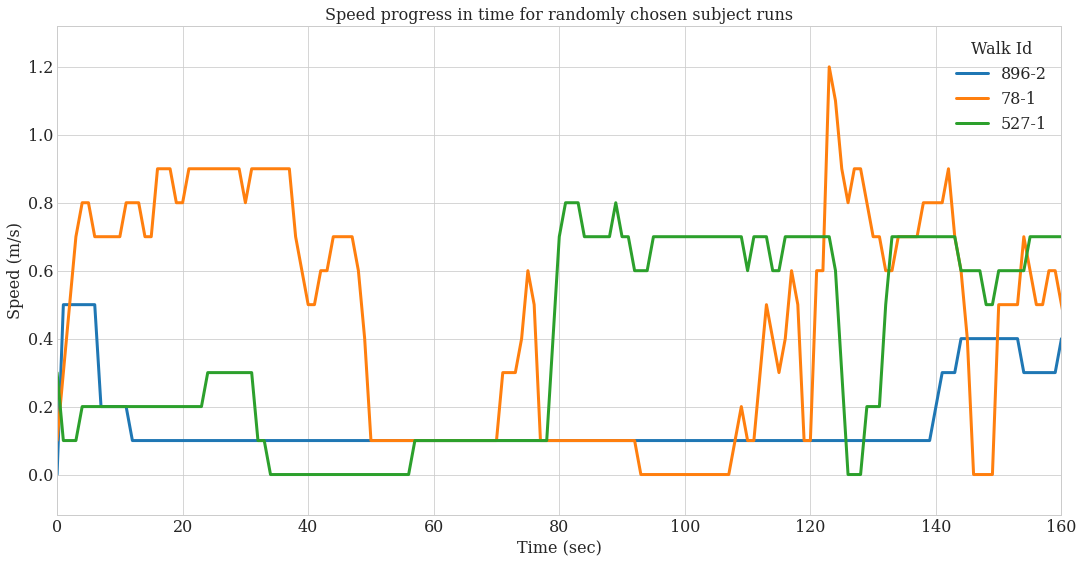

In [8]:
plt.rcParams["figure.figsize"] = (18,9)
# Plotting randomly selected walks
speed=[]
random.seed(10)
selected_walks=random.sample(walks,3)
for walk in selected_walks:
    walk_data=raw_data[raw_data['walk']==walk]
    walk_speed=walk_data['speed'].values
    walk_speed=walk_speed[::100] #downsampled 100Hz to 1Hz
    speed.append(walk_speed)

fig, ax=plt.subplots(nrows=1,ncols=1)
ax.set_xlim([0,160])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Speed (m/s)')
for walk_name,walk_speed in zip(selected_walks,speed):
    ax.plot(walk_speed, label=walk_name)
ax.legend(title="Walk Id", fancybox=True) #WalkId=SubjectId-RunId
ax.set_title('Speed progress in time for randomly chosen subject runs')  
plt.savefig("../reports/figures/{}walk_vs_time.png".format(ref)) 

# Visualize acceleration distributions in space per randomly selected speeds

In [9]:
# Extract available speeds
speeds=raw_data.drop_duplicates(subset=['speed'])
speeds=list(speeds['speed'].values)
# print('No. of available distinct speeds {}'.format(len(speeds)))
f.write('No. of available distinct speeds {} \n'.format(len(speeds)))

random.seed(10)
sel_speeds=random.sample(speeds,5)
# Extract accelration data corresponding to each selected speed 
sel_accls=[]
for speed in sel_speeds:
    accls=raw_data[raw_data['speed']==speed]
    accls=accls.drop(['stamp','SubjectId','RunId'], axis=1).values
    sel_accls.append(accls)

def plt_dist(arr, speed):
    arr=np.array(arr, dtype=float)
    mu, std = norm.fit(arr)
    x=np.linspace(arr.min(), arr.max(), 100)
    p=norm.pdf(x,mu,std)
    plt.plot(x, p, linewidth=2, label=(" %.3f"%(speed)))



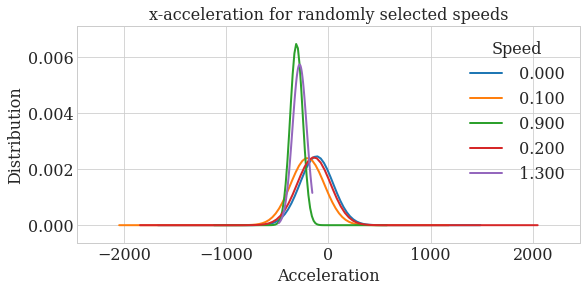

In [10]:
plt.rcParams["figure.figsize"] = (9,4)
plt.title('x-acceleration for randomly selected speeds')
for i, speed in enumerate(sel_speeds):
    plt_dist(sel_accls[i][:,0], speed)
plt.legend(title='Speed')
plt.xlabel('Acceleration')
plt.ylabel('Distribution')
plt.savefig("../reports/figures/{}x_per_speed.png".format(ref)) 

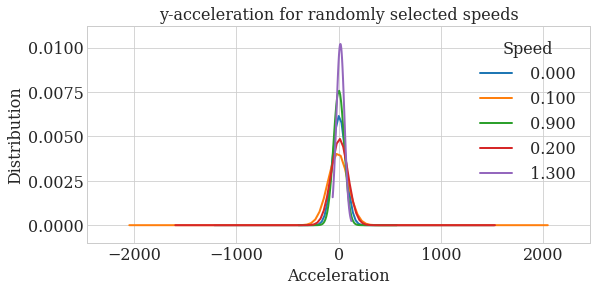

In [11]:
plt.title('y-acceleration for randomly selected speeds')
for i, speed in enumerate(sel_speeds):
    plt_dist(sel_accls[i][:,1], speed)
plt.legend(title='Speed')
plt.xlabel('Acceleration')
plt.ylabel('Distribution')
plt.savefig("../reports/figures/{}y_per_speed.png".format(ref)) 

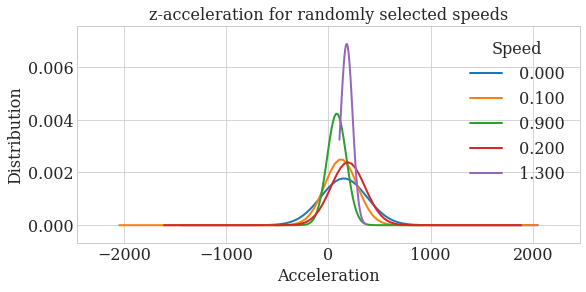

In [12]:
plt.title('z-acceleration for randomly selected speeds')
for i, speed in enumerate(sel_speeds):
    plt_dist(sel_accls[i][:,2], speed)
plt.legend(title='Speed')
plt.xlabel('Acceleration')
plt.ylabel('Distribution')
plt.savefig("../reports/figures/{}z_per_speed.png".format(ref)) 

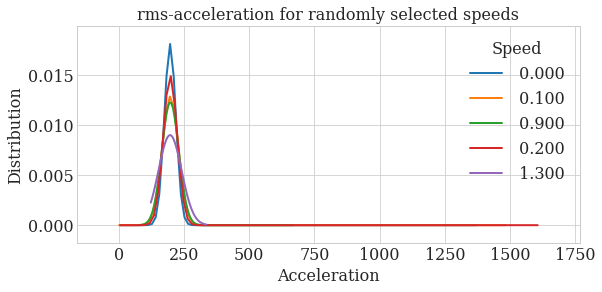

In [13]:
plt.title('rms-acceleration for randomly selected speeds')
for i, speed in enumerate(sel_speeds):
    plt_dist(sel_accls[i][:,-1], speed)
plt.legend(title='Speed')
plt.xlabel('Acceleration')
plt.ylabel('Distribution')
plt.savefig("../reports/figures/{}rms_per_speed.png".format(ref)) 

# Calculate distribution parameters against speeds 

In [14]:
#Group accelerations per speed
all_accls=[]
for speed in speeds:
    accls=raw_data[raw_data['speed']==speed]
    accls=accls.drop(['stamp','SubjectId','RunId'], axis=1).values
    all_accls.append(accls)

#Calculate params
params=[]
for i, speed in enumerate(speeds):
    x=np.array(all_accls[i][:,0], dtype=float).reshape(-1,1)
    y=np.array(all_accls[i][:,1], dtype=float).reshape(-1,1)
    z=np.array(all_accls[i][:,2], dtype=float).reshape(-1,1)
    rms=np.array(all_accls[i][:,-1], dtype=float).reshape(-1,1)
    xyz=np.concatenate([x,y,z,rms],axis=1)
    mu=np.mean(xyz, axis=0)
    std=np.std(xyz, axis=0)
    params.append(np.concatenate([mu,std],axis=0))

#Summarize results
summary=raw_data.drop_duplicates(subset=['speed'])
summary=summary.drop(['SubjectId','RunId','x','y','z','rms'], axis=1).reset_index(drop=True)
params=pd.DataFrame(params, columns=['mu_x','mu_y','mu_z','mu_rms','sigma_x','sigma_y','sigma_z','sigma_rms'])
summary=pd.concat([summary,params],axis=1)
summary=summary.reindex(columns=['stamp', 'walk','mu_x','mu_y','mu_z','mu_rms','sigma_x','sigma_y','sigma_z','sigma_rms','speed'])

sorted_summary=summary.sort_values('speed').reset_index(drop=True)
sorted_summary.to_csv("../reports/{}stat_params_vs_speed.csv".format(ref))


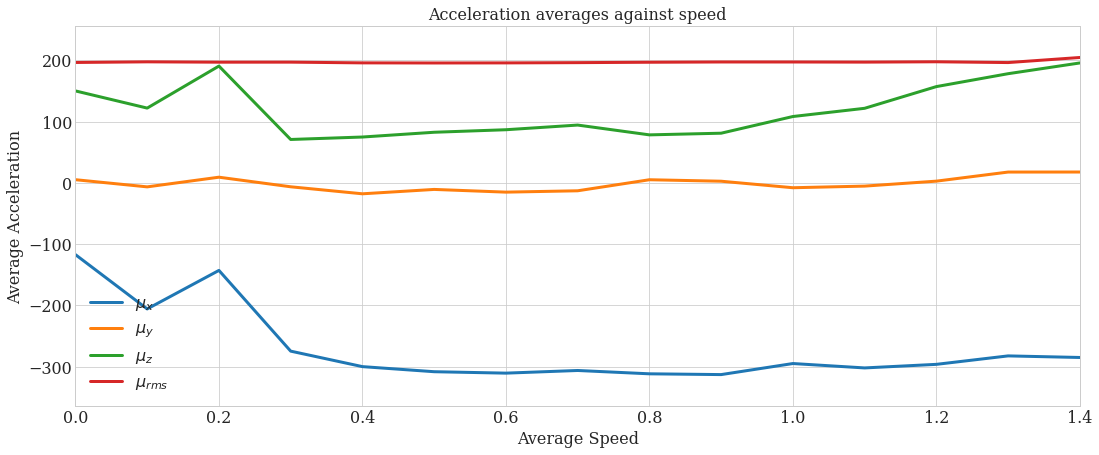

In [15]:

plt.rcParams["figure.figsize"] = (18,7)
plt.figure()
plt.title('Acceleration averages against speed')
plt.plot(sorted_summary['speed'].values,sorted_summary['mu_x'].values, label='$\mu_x$')
plt.plot(sorted_summary['speed'].values,sorted_summary['mu_y'].values, label='$\mu_y$')
plt.plot(sorted_summary['speed'].values,sorted_summary['mu_z'].values, label='$\mu_z$')
plt.plot(sorted_summary['speed'].values,sorted_summary['mu_rms'].values, label='$\mu_{rms}$')
plt.xlim([0,1.4])
plt.ylabel('Average Acceleration')
plt.xlabel('Average Speed')
plt.legend()
plt.savefig("../reports/figures/{}avg_acc_vs_speed.png".format(ref))

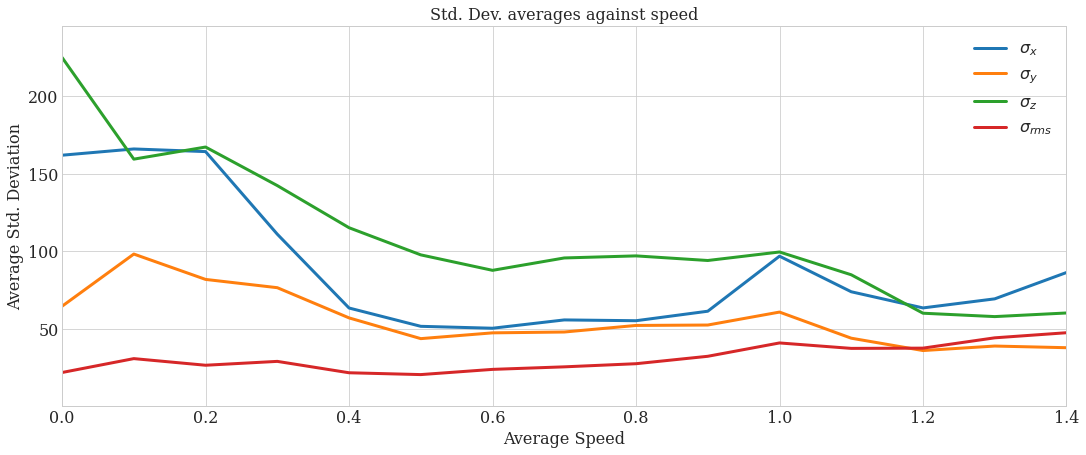

In [16]:
plt.rcParams["figure.figsize"] = (18,7)
plt.figure()
plt.title('Std. Dev. averages against speed')
plt.plot(sorted_summary['speed'].values,sorted_summary['sigma_x'].values, label='$\sigma_x$')
plt.plot(sorted_summary['speed'].values,sorted_summary['sigma_y'].values, label='$\sigma_y$')
plt.plot(sorted_summary['speed'].values,sorted_summary['sigma_z'].values, label='$\sigma_z$')
plt.plot(sorted_summary['speed'].values,sorted_summary['sigma_rms'].values, label='$\sigma_{rms}$')
plt.xlim([0,1.4])
plt.ylabel('Average Std. Deviation')
plt.xlabel('Average Speed')
plt.legend()
plt.savefig("../reports/figures/{}avg_stddev_vs_speed.png".format(ref))

# Obtain average covariance across speeds


In [17]:
all_cov=[]
#Calculate covariance matrices per speed
for i, speed in enumerate(speeds):
    x=np.array(all_accls[i][:,0], dtype=float).reshape(-1,1)
    y=np.array(all_accls[i][:,1], dtype=float).reshape(-1,1)
    z=np.array(all_accls[i][:,2], dtype=float).reshape(-1,1)
    xyz=np.concatenate([x,y,z],axis=1)
    cov=np.cov(xyz.T)
    all_cov.append(cov)
avg_cov=sum(all_cov)/len(all_cov)
avg_cov=pd.DataFrame(avg_cov.round(0), index=['x','y','z'],columns=['x','y','z'])
avg_cov.to_csv("../reports/{}avg_cov.csv".format(ref))

# Obtain covariance throughout all speeds

In [18]:
xyz=raw_data[['x','y','z']].values
cov=np.cov(xyz.T)
cov=pd.DataFrame(cov.round(0), index=['x','y','z'],columns=['x','y','z'])
cov.to_csv("../reports/{}cov.csv".format(ref))


# Plot boxplots categorizing by speeds

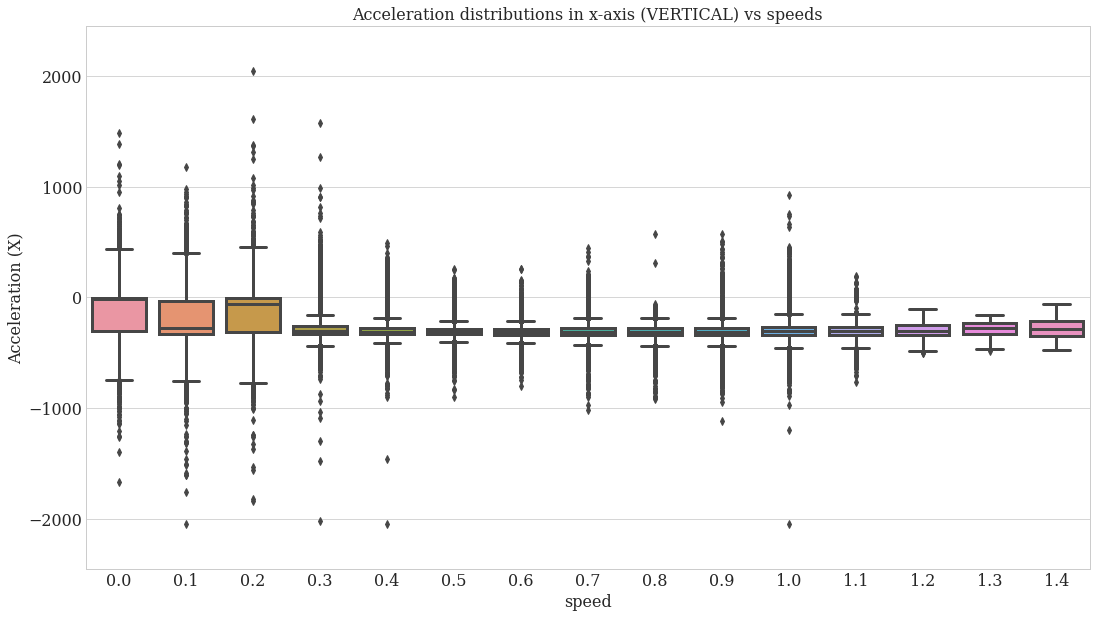

In [19]:
plt.rcParams["figure.figsize"] = (18,10)
ax=sns.boxplot(x='speed', y='x', data=raw_data)
ax.set_ylabel('Acceleration (X)')
ax.set_title('Acceleration distributions in x-axis (VERTICAL) vs speeds' )
plt.savefig("../reports/figures/{}boxplot_x_vs_speed.png".format(ref))


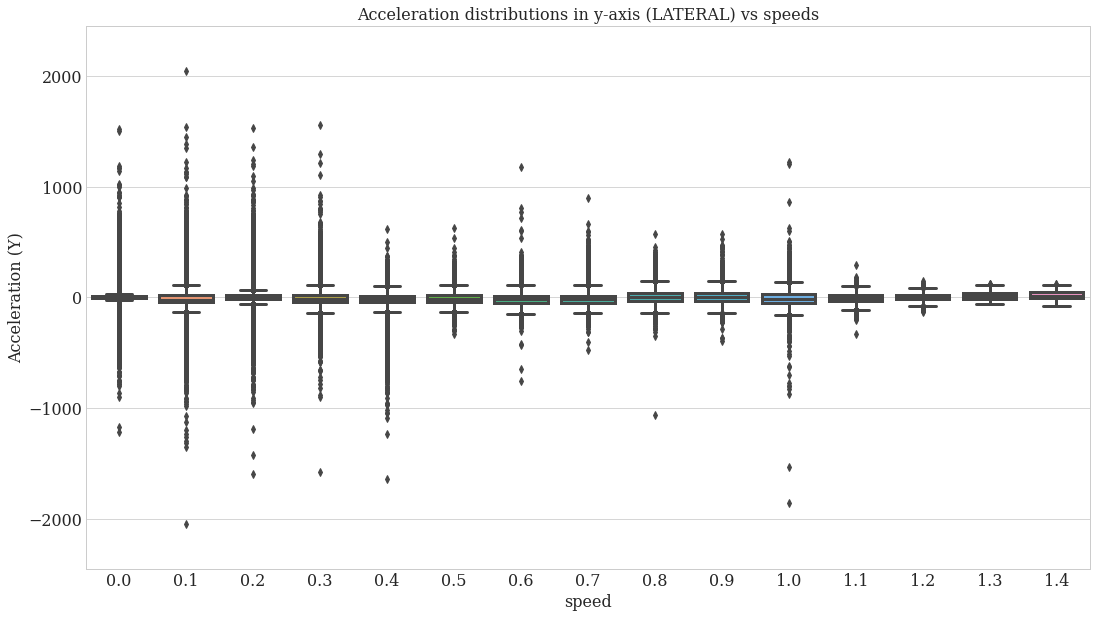

In [20]:
ax=sns.boxplot(x='speed', y='y', data=raw_data)
ax.set_ylabel('Acceleration (Y)')
ax.set_title('Acceleration distributions in y-axis (LATERAL) vs speeds' )
plt.savefig("../reports/figures/{}boxplot_y_vs_speed.png".format(ref))

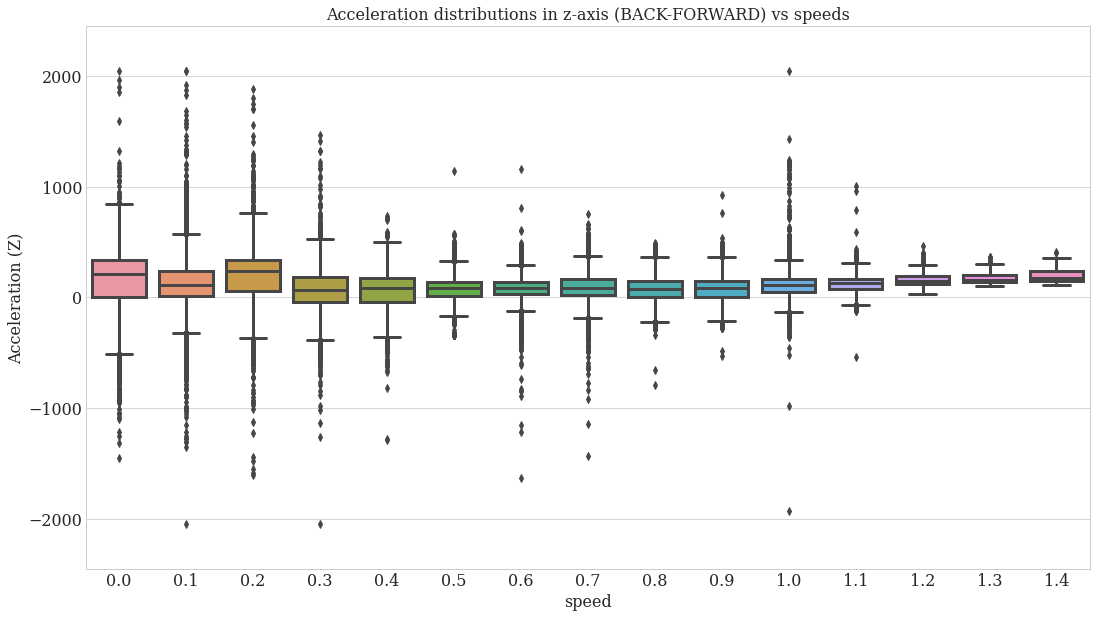

In [21]:
ax=sns.boxplot(x='speed', y='z', data=raw_data)
ax.set_ylabel('Acceleration (Z)')
ax.set_title('Acceleration distributions in z-axis (BACK-FORWARD) vs speeds' )
plt.savefig("../reports/figures/{}boxplot_z_vs_speed.png".format(ref))

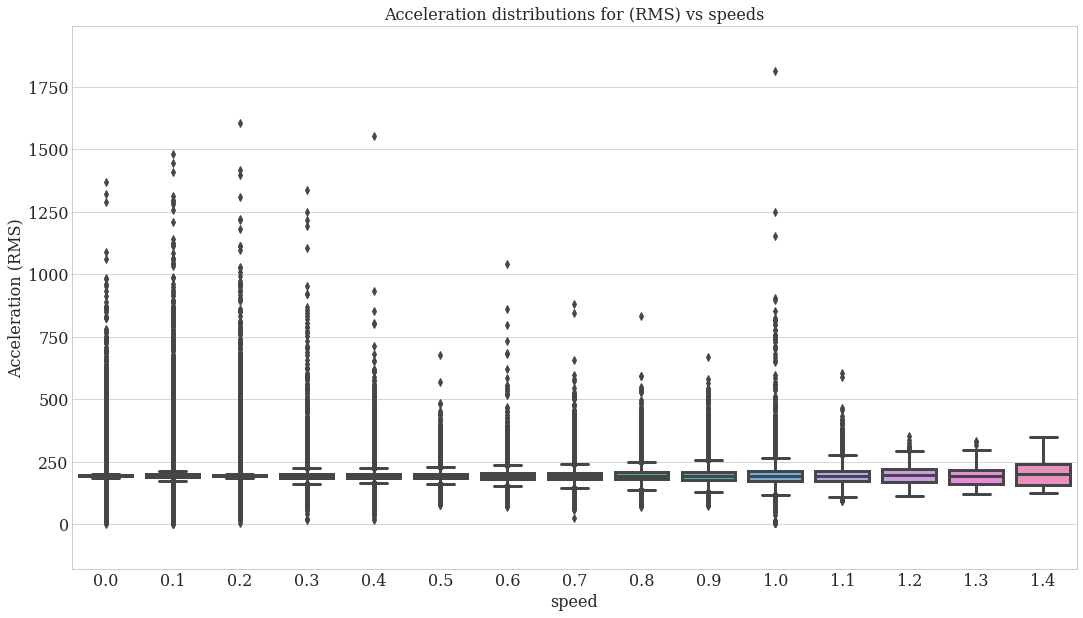

In [22]:
ax=sns.boxplot(x='speed', y='rms', data=raw_data)
ax.set_ylabel('Acceleration (RMS)')
ax.set_title('Acceleration distributions for (RMS) vs speeds' )
plt.savefig("../reports/figures/{}boxplot_rms_vs_speed.png".format(ref))

In [23]:
f.close()